# Dirichlet Process Mixture Models: continuous data

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import theano
import theano.tensor as tt
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context('notebook')
np.random.seed(12345)
rc = {'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 20, 'font.size': 20, 
      'legend.fontsize': 12.0, 'axes.titlesize': 10, "figure.figsize": [14, 6]}
sns.set(rc = rc)
sns.set_style("whitegrid")

## Step 1: Prepare the data

Let's use an R dataset called 'old faithful' to estimate the density of waiting times between eruptions

In [2]:
from statsmodels.datasets import get_rdataset
df = get_rdataset(dataname = "faithful").data

In [3]:
df.head()

,eruptions,waiting
0,3.600,79
1,1.800,54
2,3.333,74
3,2.283,62
4,4.533,85


Lets standardize the waiting times

In [4]:
df["std_waiting"] = (df.waiting - df.waiting.mean()) / df.waiting.std()
df.head()

,eruptions,waiting,std_waiting
0,3.600,79,0.596025
1,1.800,54,-1.242890
2,3.333,74,0.228242
3,2.283,62,-0.654437
4,4.533,85,1.037364


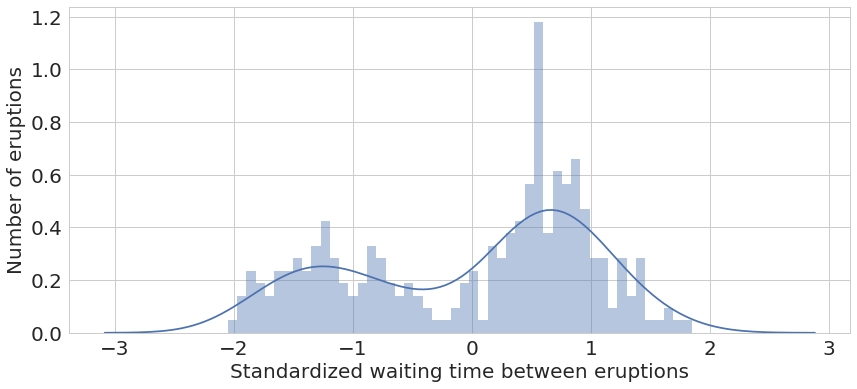

In [5]:
import plotly as py
fig, ax = plt.subplots()
ax = sns.distplot(bins = 50, kde = True, a = df.std_waiting)
ax.set_xlabel('Standardized waiting time between eruptions')
ax.set_ylabel('Number of eruptions');
#py.offline.iplot_mpl(fig)
#plt.savefig('figpath1.svg', dpi = 400, bbox_inches = "tight")

Truncate the DP components that are stored after a fixed number of components, $K$.  
Ohlssen et al. (2007) proposed that $K > 5\alpha + 2$ is sufficient to capure almost all the of the mixture weights ($\sum_{k = 1}^{K} \pi_{k} > 0.999$)  
* We shall verify the suitability of the above truncation by checking the # of components that contribute non-negligible mass to the mixture  
** If, in our simulations, all components contribute non-negligible mass to the mixture, we have truncated the DP TOO EARLY**

In [6]:
N = df.shape[0] # the number of data points
# the number of clusters for N data points is < K
# K is the number of truncated components. recall that # components > # clusters
K = 30 # let's start with 13 components and we will perform a check for its suitability

In [7]:
N

272

## Step 2: Build the model

The $GEM$ is a type of stick breaking using beta distributions with $a = 1, b = \alpha$, i.e $V_k \sim Beta(1, \alpha)$

\begin{split}\begin{align*}
    \alpha
        & \sim \textrm{Gamma}(1, 1) \\
    v_1, \ldots, v_K
        & \sim \textrm{Beta}(1, \alpha) \\
    \pi_i
        & = v_i \prod_{j = i - 1}^i (1 - v_j) \\
    \\
    \lambda_1, \ldots, \lambda_K
        & \sim U(0, 5) \\
    \tau_1, \ldots, \tau_K
        & \sim \textrm{Gamma}(1, 1) \\
    \mu_i\ |\ \lambda_i, \tau_i
        & \sim N\left(0, (\lambda_i \tau_i)^{-1}\right) \\
    \\
    y\ |\ \pi_i, \lambda_i, \tau_i, \mu_i
        & \sim \sum_{i = 1}^K \pi_i\ N(\mu_i, (\lambda_i \tau_i)^{-1})
\end{align*}\end{split}

In [8]:
def stick_breaking(v):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - v)[:-1]])

    return v * portion_remaining

In [9]:
with pm.Model() as dpmm_normal:
    
    # specify the priors
    alpha = pm.Gamma('alpha', 1.0, 1.0)
    v = pm.Beta('v', 1.0, alpha, shape = K)
    pi = pm.Deterministic('pi', stick_breaking(v)) # stick breaking proportions

    lambda_ = pm.Uniform('lambda', 0, 5, shape = K)
    tau = pm.Gamma('tau', 1.0, 1.0, shape = K)
    mu = pm.Normal('mu', 0, tau = lambda_ * tau, shape = K)
    
    # specify the data likelihood
    obs = pm.NormalMixture('obs', pi, mu, tau = lambda_ * tau, observed = df.std_waiting.values)

## Step 3: Sample from the posterior

In [10]:
with dpmm_normal:
    step = pm.NUTS(target_accept = 0.999, adapt_step_size = 0.001, max_treedepth = 15)
    posterior = pm.sample(draws = 1000, njobs = 2, tune = 500, step = step)

 86%|████████▌ | 1284/1500 [06:22<01:04,  3.35it/s]/home/emaasit/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning:

The acceptance probability in chain 1 does not match the target. It is 0.989945094569, but should be close to 0.999. Try to increase the number of tuning steps.

/home/emaasit/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning:

Chain 1 contains 109 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.

100%|██████████| 1500/1500 [07:25<00:00,  3.37it/s]/home/emaasit/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning:

The acceptance probability in chain 0 does not match the target. It is 0.992099375285, but should be close to 0.999. Try to increase the number of tuning steps.

/home/emaasit/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning:

Chain 0 contains 137 diverging samples after 

## Step 4: Diagnose convergence of MCMC chains

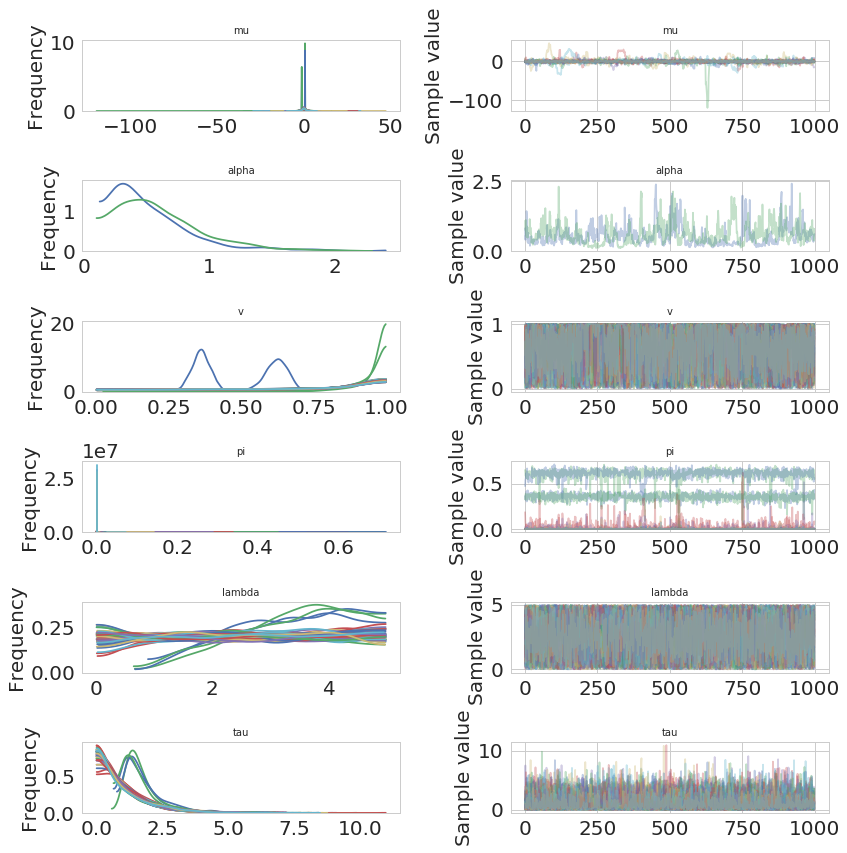

In [28]:
pm.traceplot(posterior);

In [25]:
pm.gelman_rubin(posterior)

{'alpha': 1.0080269812585749,
 'lambda': array([ 1.00261524,  1.00207105,  0.99952837,  0.99950069,  0.99964553,
         1.00113068,  0.99967174,  1.00011836,  1.00181656,  0.99970133,
         1.00039853,  0.99967156,  1.00059865,  1.00170887,  0.9995857 ,
         0.99970128,  0.99967622,  1.00011792,  1.00111911,  0.99950413,
         1.00062978,  1.00001135,  1.00003356,  0.99953912,  1.00005941,
         0.99972711,  0.99982907,  0.99986355,  1.00365396,  1.00294676]),
 'mu': array([ 26.10294038,  26.24598617,   0.9995029 ,   1.00552949,
          0.99960933,   1.00058404,   0.99950899,   1.00188756,
          1.01231521,   1.01144718,   1.00163125,   0.99975611,
          1.00389992,   1.00797493,   1.00612873,   0.99997833,
          1.00156783,   0.99966149,   1.000088  ,   1.00130423,
          1.00005798,   0.99965323,   0.99977334,   1.00102855,
          0.99964782,   1.00614335,   1.00308333,   1.01336256,
          1.00713022,   1.01736359]),
 'pi': array([ 4.30079909,  

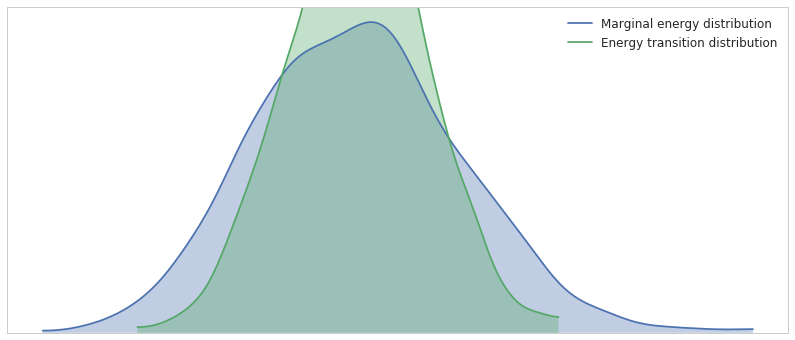

In [15]:
pm.energyplot(posterior);

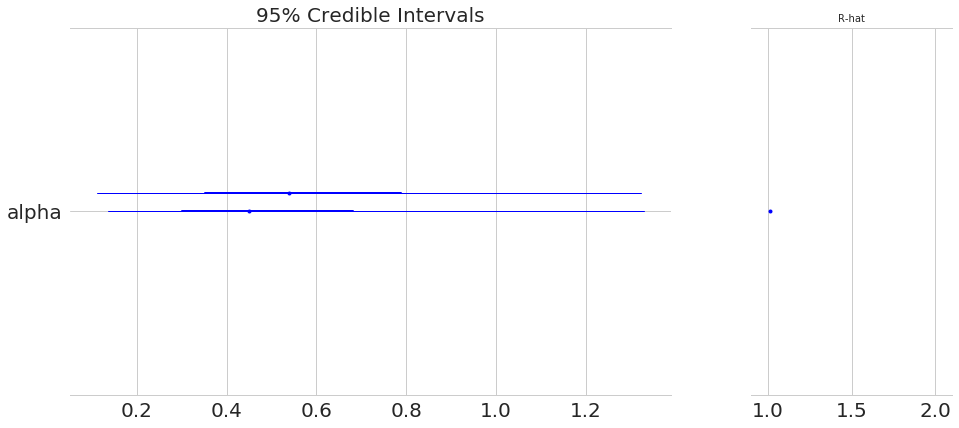

In [26]:
pm.forestplot(posterior, varnames = ["alpha"]);

## Step 5: Criticise the model

The posterior distribution of $\alpha$ is highly concentrated between 0.25 and 1.

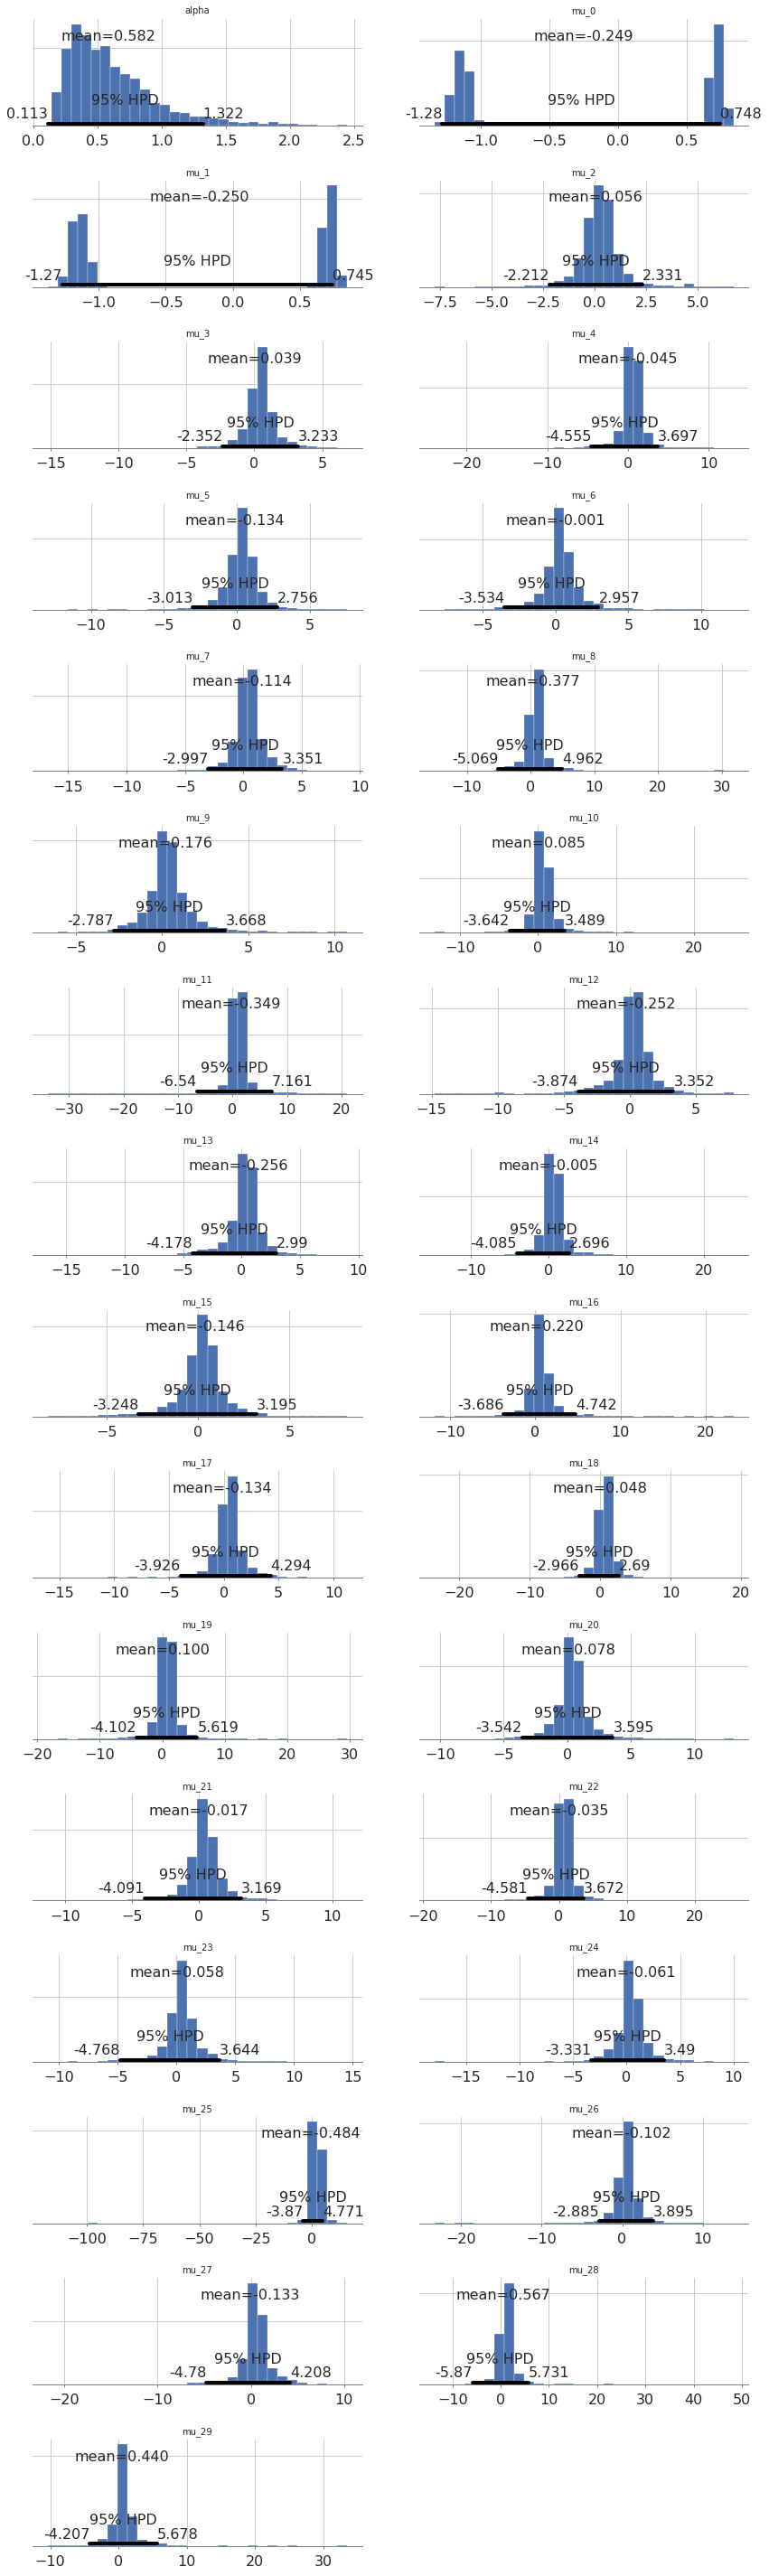

In [31]:
pm.plot_posterior(posterior, varnames = ["alpha", "mu"]);

### Check the suitability of our truncation
Plot the posterior expectation of proportions of each component.  

The figure below shows that six components have posterior weight/proportion. This shows that truncation at K = 30 captures all the components in this data.

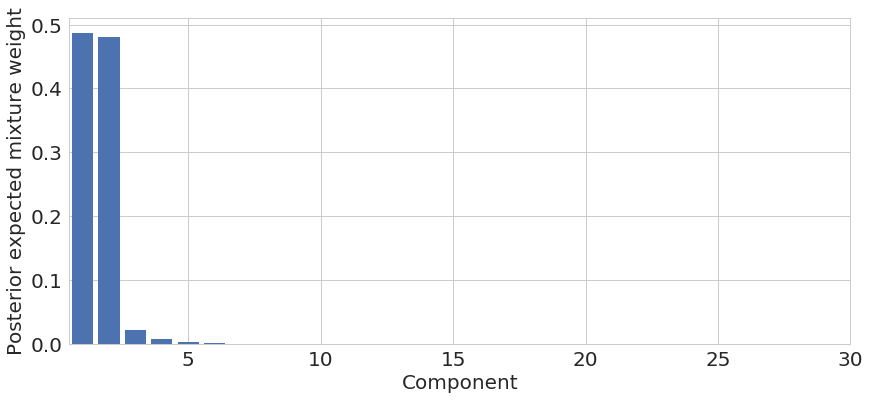

In [56]:
fig, ax = plt.subplots()

plot_pi = np.arange(K) + 1

ax.bar(plot_pi, posterior['pi'].mean(axis = 0)); # axis 0 is the columns

ax.set_xlim(0.5, K);
ax.set_xlabel('Component');

ax.set_ylabel('Posterior expected mixture weight');

### Visualize the posterior density estimate

In [58]:
y_plot = np.linspace(-3, 3, 200)

In [60]:
import scipy as sp
post_pdf_contribs = sp.stats.norm.pdf(np.atleast_3d(y_plot),
                                      posterior['mu'][:, np.newaxis, :],
                                      1. / np.sqrt(posterior['lambda'] * posterior['tau'])[:, np.newaxis, :])

post_pdfs = (posterior['pi'][:, np.newaxis, :] * post_pdf_contribs).sum(axis=-1)

post_pdf_low, post_pdf_high = np.percentile(post_pdfs, [2.5, 97.5], axis=0)

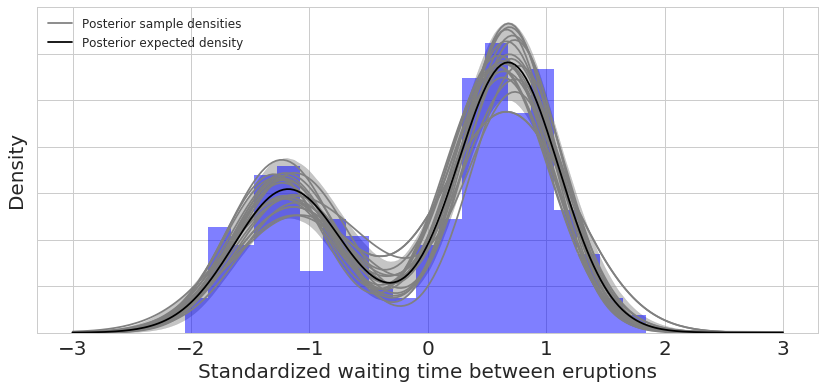

In [65]:
fig, ax = plt.subplots()

n_bins = 20
ax.hist(df.std_waiting.values, bins = n_bins, normed=True, color = "blue", lw = 0, alpha = 0.5);

ax.fill_between(y_plot, post_pdf_low, post_pdf_high, color ='gray', alpha = 0.45);    

ax.plot(y_plot, post_pdfs[0], c = 'gray', label = 'Posterior sample densities');

ax.plot(y_plot, post_pdfs[::100].T, c = 'gray');
ax.plot(y_plot, post_pdfs.mean(axis = 0), c = 'k', label = 'Posterior expected density');

ax.set_xlabel('Standardized waiting time between eruptions');

ax.set_yticklabels([]);
ax.set_ylabel('Density');

ax.legend(loc = 2);

Decompose the above density into its mixture components

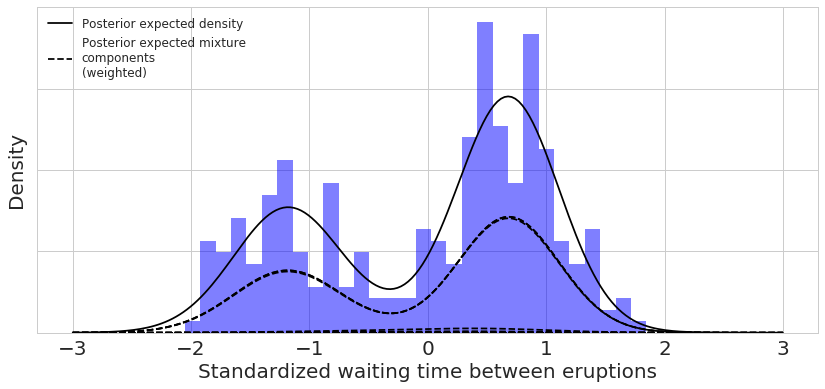

In [73]:
fig, ax = plt.subplots()

n_bins = 30
ax.hist(df.std_waiting.values, bins=n_bins, normed=True, color="blue", lw=0, alpha=0.5);

ax.plot(y_plot, post_pdfs.mean(axis=0), c='k', label='Posterior expected density');

ax.plot(y_plot, (posterior['pi'][:, np.newaxis, :] * post_pdf_contribs).mean(axis=0)[:, 0],
        '--', c='k', label='Posterior expected mixture\ncomponents\n(weighted)');

ax.plot(y_plot, (posterior['pi'][:, np.newaxis, :] * post_pdf_contribs).mean(axis=0),
        '--', c='k');

ax.set_xlabel('Standardized waiting time between eruptions');

ax.set_yticklabels([]);
ax.set_ylabel('Density');

ax.legend(loc=2);